# Ideal ORE, Non-uniform
## Bayes Vulnerability

In [49]:
import collections
import math
import numpy as np
import pandas as pd
from scipy.special import perm, comb # for nPk
from itertools import combinations
from sympy.utilities.iterables import partitions, variations, multiset_permutations
from sympy.functions.combinatorial.numbers import stirling
from decimal import Decimal
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

uni_ore_bayes(n, k) 
- included for reference 
$$ V_1 [C \triangleright \pi ]  =  \frac{\sum_{i=1}^{min(n, k)} \text{stirling2}(n, i)\times i!}{k^n}  $$

In [2]:
def uni_ore_bayes(n, k):
    outputs = 0
    inputs = 0
    for c in range(n):
        if k < c+1:
            break
        s2 = stirling(n, c+1)
        outputs = outputs + (math.factorial(c+1) * s2)
        inputs = inputs + (perm(k, c+1) * s2)
    return outputs / inputs

int_part_to_list(p) takes integer partition as input and outputs a list representation.

Ex:
```python
p = {3:1, 2:2, 1:3}
p_list = [3, 2, 2, 1, 1, 1]
```

In [3]:
def int_part_to_list(p):
    p_list = []
    for key in p.keys():
        for v in range(p[key]):
            p_list.append(key)
    return p_list

ore_calc_max_prob(msp, Pi) takes the multiset_permutation as output by multiset_permutation(p_list) and the prior Pi and outputs the maximum probability for that group of columns

Currently, done with brute force, calculating the nCk number of cases and finding the max probability where k = the number of blocks

In [50]:
def ore_calc_max_prob(msp, Pi):
    k = len(msp)
    candidate_probabilities = []
    for i in combinations(Pi, k): # for all nCk cases, determine what the probability would be
        prob = 1
        term = 1
        for x in range(len(msp)):
            term = pow(i[x], msp[x]) # msp pow will be the same, but pi will not be. 
            prob = prob * term
        candidate_probabilities.append(prob) # add to list
    return max(candidate_probabilities) # return max

In [48]:
msp = [1,2,1]
Pi = [1/8, 1/4, 1/2, 1/8]
ore_calc_max_prob(msp, Pi)

0.0078125

ore_calc_set_partitions(n,p) takes n and the integer partition and outputs how many columns correspond to this case

$$ \frac{n!}{\prod_{i} (i ! ) ^ \text{multipilicity}} $$ where $i$ is an integer in the integer partition

Ex: 
```python
n = 4, p = {2:2}
sp = 6
```

In [5]:
def ore_calc_set_partitions(n,p):
    num = math.factorial(n) # numerator is all blocks!
    den = 1
    for i in p.keys():
        den = den * math.pow(math.factorial(i), p[i])
    sp = num / den
    return sp

nonuni_ideal_ore_post_bayes(n, k, Pi) takes n, k, and Pi and calculates the posterior Bayes vulnerability 

In [6]:
def nonuni_ideal_ore_post_bayes(n, k, Pi):
    pbvsum = 0
    for p in partitions(n, m=k):
        p_list = int_part_to_list(p) # turn to list
        c = ore_calc_set_partitions(n,p) # check
        insum = 0
        for msp in multiset_permutations(p_list): # for all multiset partitions,
            prob = 0
            prob = ore_calc_max_prob(msp, Pi) # find probability for case
            val = c * prob # multipy by probability
            insum = insum + val
        pbvsum = pbvsum + insum # add to running sum
    return pbvsum

n = 3, k = 3 [1/2, 1/3, 1/6], the posterior Bayes vulnerability is 17/24 ~ 0.70833

In [227]:
n = 3
k = 3
probs = [1/2, 1/3, 1/6]
uni_probs = [1/3, 1/3, 1/3]
print("First two values should be the same.")
print("****Uniform, uniform function: ", uni_ore_bayes(n, k))
print("****Uniform, generic funciton: ", nonuni_ideal_ore_post_bayes(n, k, uni_probs))
print("Should be ~0.708")
print("****Nonuniform, generic function: ", nonuni_ideal_ore_post_bayes(n, k, probs))

First two values should be the same.
****Uniform, uniform function:  0.481481481481481
****Uniform, generic funciton:  0.48148148148148145
Should be ~0.708
****Nonuniform, generic function:  0.7083333333333333


In [228]:
n = 4
k = 4
probs = [1/2, 1/4, 1/8, 1/8]
uni_probs = [1/4, 1/4, 1/4, 1/4]
print("First two values should be the same.")
print("****Uniform, uniform function: ", uni_ore_bayes(n, k))
print("****Uniform, generic funciton: ", nonuni_ideal_ore_post_bayes(n, k, uni_probs))
print("****Nonuniform, generic function: ", nonuni_ideal_ore_post_bayes(n, k, probs))

First two values should be the same.
****Uniform, uniform function:  0.292968750000000
****Uniform, generic funciton:  0.29296875
****Nonuniform, generic function:  0.5234375


ppdf(n_range, k, probs) generates a dataframe (table) of n ranging from 1 to n_range of the prior and posterior Bayes vulnerability

In [7]:
def ppdf(n_range, k, probs):
    post_bayes_vs = []
    prior_bayes_vs = []
    n = []
    i = 0
    for x in range(n_range):
        i = i + 1
        n.append(i)
        post = nonuni_ideal_ore_post_bayes(i, k, probs)
        post_bayes_vs.append(post)
        prior = pow(probs[0], i) # assumes ordered prior, with biggest first
        prior_bayes_vs.append(prior)
    df = pd.DataFrame(
        {'n':n,
         'prior':prior_bayes_vs,
         'posterior':post_bayes_vs
        }
    )
    return df

In [53]:
n_range = 3
k = 3
probs = [1/2, 1/3, 1/6]
df_small = ppdf(n_range, k, probs)

In [54]:
df_small

,n,prior,posterior
0,1,0.500,0.5000000000
1,2,0.250,0.5833333333
2,3,0.125,0.7083333333


From n = 1 to 25
and k = 20 plaintext values
such that the first value has probability 1/2 and 19 have equal probability 1/38

In [231]:
n_range = 25
k = 20
probs = [1/2, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38,1/38, 1/38, 1/38, 1/38, 1/38, 1/38, 1/38]
df_half = ppdf(n_range, k, probs)

In [232]:
df_half

,n,prior,posterior
0,1,0.5000000000,0.5000000000
1,2,0.2500000000,0.2763157895
2,3,0.1250000000,0.1478531856
3,4,0.0625000000,0.0792480682
4,5,0.0312500000,0.0427528468
5,6,0.0156250000,0.0232545793
6,7,0.0078125000,0.0127710946
7,8,0.0039062500,0.0070922206
8,9,0.0019531250,0.0039895670
9,10,0.0009765625,0.0022778794


In [233]:
df_half.to_csv(r'data\df_half_n25_k20', index = None, header = True)

In [ ]:
df_half = pd.read_csv('data\df_half_n25_k20')

## Graphs

In [8]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
font_choice = 14
plt.rcParams.update(plt.rcParamsDefault)
rc_fonts = {
    "text.usetex": True,
    "font.size": font_choice,
    'mathtext.default': 'regular',
    'axes.titlesize': font_choice,
    "axes.labelsize": font_choice,
    "legend.fontsize": font_choice,
    "xtick.labelsize": font_choice,
    "ytick.labelsize": font_choice,
    'figure.titlesize': font_choice,
    'figure.figsize': (8,5.25),
    'text.latex.preamble': [r'\usepackage{amsmath,nicefrac, sansmath}', 
                            r'\sansmath'],
    "font.family": "sans-serif",#"font.sans-serif": "computer modern",
    }
mpl.rcParams.update(rc_fonts)

In [9]:
def graph_it_bayes(n_range, k, df):
    ax = plt.figure().gca()
    plt.plot('n', 'prior', 
             data=df,
             label="prior")
    plt.plot('n', 'posterior',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="posterior")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xlim(left = 0, right = n_range+1)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    plt.title('Bayes vulnerability under non-uniform prior, k = {}'.format(k))
    plt.legend(loc='upper left') # legend adjusted so it doesn't run into annotations
    plt.show()
    plt.close()

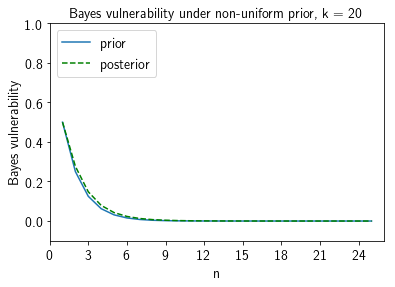

In [234]:
graph_it_bayes(n_range, k, df_half)